In [2]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact
from os import path

import plotly.graph_objects as go
import pandas as pd

# from quimb import *
import time


In [3]:
def Hilbertspace_Zr(N,r):

    states=np.zeros((r**N,N),dtype=int)

    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

def p_transpose_2(V,Na,Nb):
# partial transpose with respect to subsystem 2
# the basis of NaxNb density matrix is defined by Nb*(i-1)+j,
# i,j=1,2,3 spans the Hilbert space of subsystem 1 and 2 respectively
    U=np.zeros((Na*Nb,Na*Nb), dtype=np.complex128)
    for i_1 in range(Na):
        for i_2 in range(Na):
#             print(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)].shape)
            U[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)]=np.transpose(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)])

    return U

def vNent_calc(rho,epsilon=1e-9):
    chi0 =np.linalg.eigvalsh(rho)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
    return -np.sum(chi2*np.log(chi2))


# Negativity spectrum:

12
13
14
15
16
Finished, elapsed time = 51608.13 sec


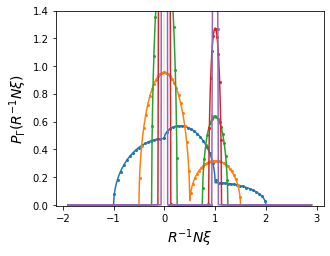

In [44]:
Nrep=100
r=4 # local Hilbert space dim
symm=1

La=3
Lb=La
Na=r**La
Nb=r**Lb

if symm==1:
    Nab_r=r**(La+Lb-1)
    s_ab=Hilbertspace_Zr(La+Lb,r)
    i_ab=np.zeros((r**(La+Lb-1),r),dtype=int)
    ### indices of r multiples
    for i_Zr in range(r):
        i_ab[:,i_Zr]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_Zr)[:,0]
else:
    Nab_r=Na*Nb

# L_sw=range(8,13)
L_sw=range(12,17)
# L_sw=[12]

v1T=np.zeros((Nrep*Nb*Na,len(L_sw)))
neg=np.zeros((Nrep,len(L_sw)))


t_timer= time.time()
for i_l in range(len(L_sw)):
    L=L_sw[i_l]
    print(L)

    Lc=L-La-Lb
    Nc=r**Lc
    
    if symm==1:
        Nc_r=r**(Lc-1)
        s_c=Hilbertspace_Zr(Lc,r)
        i_c=np.zeros((r**(Lc-1),r),dtype=int)
        ### indices of r multiples
        for i_Zr in range(r):
            i_c[:,i_Zr]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_Zr)[:,0]
    else:
        Nc_r=Nc

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)

    for i_r in range(Nrep):
        i_r
        if symm==1:
            X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
    #         X[i_ab[:,0],:] = np.random.randn(Ne_ab,Nc)+ 1j*np.random.randn(Ne_ab,Nc)
        else:
        #### no symmetry
            X=np.random.randn(Nab_r,Nc)+1j*np.random.randn(Nab_r,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT2 = p_transpose_2(rho,Na,Nb)
        l1T=np.linalg.eigvalsh(rT2)
        v1T[i_r*Nb*Na:(i_r+1)*Nb*Na,i_l] = Nab_r *l1T
        neg[i_r,i_l]=np.sum(np.abs(l1T))

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")

out_dir = "/gscratch/home/hshapourian/RMT/data/" #'data/' 
if symm==1:
    f1= 'NS_r_%d_LA_%d_symm.npz' % (r,La+Lb)
else:
    f1= 'NS_r_%d_LA_%d.npz' % (r,La+Lb)

fname = out_dir+f1
np.savez(fname, evals=v1T, L_sw=L_sw, Nrep=Nrep)


#############################################
######### histograms ###################

def semicirc_dist(N,Q,x,x0):
    # my Q is from Ludwig's paper
    R= 2*sqrt(Q)
    fx= 2/(pi*R**2)*(R**2-(x-x0)**2+0j)**0.5
    return fx

num_bins = 50

plt.figure(figsize=(4.8,3.6))
for i_l in range(len(L_sw)):

    n, bin_edges = np.histogram(v1T[:,i_l], bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    if symm==1:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])    
    else:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])  
        
    plt.plot(bins_center,n,'o',markersize=2,color='C%d' % (i_l))
    
    L=L_sw[i_l]
    Lc=L-La-Lb
    xplot=np.linspace(-1.9,2.9,1000)
    if symm==1:
        fx1= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,0)*(r-1)/r
        fx2= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,1)/r
        plt.plot(xplot,np.real(fx1+fx2),color='C%d' % (i_l))
    else:
        fx= semicirc_dist(Nab_r,Na*Nb/r**Lc,xplot,1)
        plt.plot(xplot,np.real(fx),color='C%d' % (i_l))


lw=0.2
ymax=1.4
plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)

fsize=14
plt.ylim(-0.01,ymax)
# plt.yticks(np.arange(0.,2.1,0.5))
# plt.legend()
if symm==1:
    plt.ylabel(r'$P_\Gamma(R^{-1} N \xi)$',fontsize = fsize)
    plt.xlabel(r"$R^{-1} N \xi$",fontsize = fsize)
else:
    plt.ylabel(r'$P_\Gamma(N \xi)$',fontsize = fsize)
    plt.xlabel(r"$N \xi$",fontsize = fsize)

plt.show()

ES was loaded!
14
15
16


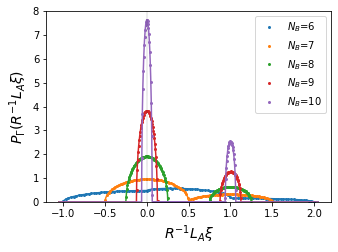

In [50]:
out_dir = "/gscratch/home/hshapourian/RMT/data/" #'data/' 
r=4 # local Hilbert space dim
symm=1

La=3
Lb=La
Na=r**La
Nb=r**Lb

if symm==1:
    f1= 'NS_r_%d_LA_%d_symm.npz' % (r,La+Lb)
    Nab_r=r**(La+Lb-1)
else:
    f1= 'NS_r_%d_LA_%d.npz' % (r,La+Lb)
    Nab_r=Na*Nb

fname = out_dir+f1

npzfile = np.load(fname)
v1T=npzfile['evals']
L_sw=npzfile['L_sw']
print('ES was loaded!')

def semicirc_dist(N,Q,x,x0):
    # my Q is from Ludwig's paper
    R= 2*sqrt(Q)
    fx= 2/(pi*R**2)*(R**2-(x-x0)**2+0j)**0.5
    return fx


plt.figure(figsize=(4.8,3.6))
for i_l in range(len(L_sw)):
    L=L_sw[i_l]
    Lc=L-La-Lb

    if r**Lc > 4* r**(La+Lb)+1:
        num_bins = 200
        print(L)
    else:
        num_bins = 100

    n, bin_edges = np.histogram(v1T[:,i_l], bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2

    if symm==1:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])    
    else:
        n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])  
        
    plt.plot(bins_center,n,'o',markersize=2,color='C%d' % (i_l), label='$N_B$=%d' % (Lc))
    
    xplot=np.linspace(-1.05,2.05,1000)
#     xplot=np.linspace(-1.1,3.1,1000)
    if symm==1:
        fx1= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,0)*(r-1)/r
        fx2= semicirc_dist(Nab_r/r,Na*Nb/r**(Lc+1),xplot,1)/r
        plt.plot(xplot,np.real(fx1+fx2),color='C%d' % (i_l))
    else:
        fx= semicirc_dist(Nab_r,Na*Nb/r**Lc,xplot,1)
        plt.plot(xplot,np.real(fx),color='C%d' % (i_l))


lw=0.2
ymax=8.0
plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)
plt.ylim(-0.01,ymax)
# plt.xlim(-2,3)
plt.yticks(np.arange(0.,ymax+0.1,1.0))
plt.legend()
fsize=14
if symm==1:
    plt.ylabel(r'$P_\Gamma(R^{-1} L_A \xi)$',fontsize = fsize)
    plt.xlabel(r"$R^{-1} L_A \xi$",fontsize = fsize)
else:
    plt.ylabel(r'$P_\Gamma(N \xi)$',fontsize = fsize)
    plt.xlabel(r"$N \xi$",fontsize = fsize)
    
plt.tight_layout()
if symm==1:
    plt.savefig('figs/sc_r_%d_vs_NB_NA_%d_symm.pdf' % (r,La+Lb))
else:
    plt.savefig('figs/sc_r_%d_vs_NB_NA_%d.pdf' % (r,La+Lb))
plt.show()

In [23]:
print(v1T.shape[0]/(Na*Nb))

10000.0
